### SOUMAHORO Youssouf

### Enseignant: Gilles GASSO








# TP: Predict English level
    The goal is to predict English level of applicants based on their written texts. Three English
    levels are in play, namely : B2, B1 ou C2 (knowing that C2 > B1 > B2). From each raw text
    56 features are extracted. These features are for instance the number of words, the number of
    sentences, lexical and syntactic indexes. From these features we aim to predict the label y ∈
    {C2, B1, B2} related to the text.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

### 1. Load the training set.

In [2]:
train = pd.read_csv("englevel_train.csv", index_col=None, sep= ",")
Ytrain = train["level1"].values
Xtrain = train.drop("level1", axis=1).values
train.head()

,sentences,words,letters.all,syllables,punct,avg.sentc.length,avg.word.length,avg.syll.word,sntc.per.word,TTR,...,Herdan's C,Maas a,Maas lgV0,MTLD,Root TTR,Summer,TTR.1,Uber index,Yule's K,level1
0,10,170,817,268,23,17.000000,4.805882,1.576471,0.058824,0.623529,...,0.91,0.20,4.83,97.21,8.13,0.88,0.62,24.25,136.33,B2
1,9,85,311,104,25,9.444444,3.658824,1.223529,0.105882,0.588235,...,0.88,0.25,3.58,30.27,5.42,0.81,0.59,16.15,246.37,B1
2,8,50,214,66,14,6.250000,4.280000,1.320000,0.160000,0.740000,...,0.92,0.21,4.08,53.85,5.23,0.85,0.74,22.07,232.00,B1
3,18,237,999,319,32,13.166667,4.215190,1.345992,0.075949,0.578059,...,0.90,0.21,4.90,80.02,8.90,0.88,0.58,23.69,121.78,B2
4,9,105,423,147,13,11.666667,4.028571,1.400000,0.085714,0.638095,...,0.90,0.22,4.26,56.86,6.54,0.86,0.64,20.94,175.96,B1


In [3]:
test = pd.read_csv("englevel_test.csv", index_col=None, sep= ",")
Ytest = test["level1"].values
Xtest = test.drop("level1", axis=1).values

### 2. We want first to learn a linear SVM by following the procedure described below.

   x −→ [normalizing x : x ← (x − x̄)/σ ]−→ [Model f (x) = w > x + b ]−→ Predict ŷ
    

### Explain each step of the pipeline building and its configuration. What is (are) the hyper-parameter(s) of the model defined by the pipeline ?
   
       Pour faire un SVM nous avons besoin de normaliser les données et ensuite construire notre modèle
       SVM sur ces données normalisées. Pipline nous permet de combiner ces deux étapes en une seule,
       Pipline transforme nos données à notre guise et ensuite nous donne un estimateur final. Avec 
       Pipline on peut construire plusieurs modèles à la fois avec de différentes transformations.
       Le Pipeline est construit en utilisant une liste de paires, contenant le nom que nous  voulons
       donner à chaque étape et un objet estimateur:(key, value)
       Ici, nous appliqquons une normalisation sur les données avant d'ajuster le modèle donc nous            devons spécifier le **normaliseur** et le **classifieur**
       
        Comme nous voulons faire du SVM linéaire, nous avons seulement besoin du paramètre de  
        régularisation C

### 3. The pipeline being built, the hyper-parameters are optimized using a grid search as in the previous exercise.


     Nous allons écrire une fonction qui fera le **pipeline** et le **GridSearch** 

In [103]:
def pipeline_gridsearch(X,y,steps,grid_param,X_test=None,scoring="accuracy",cv=2):
    """
    construire un modèle avec pipeline et gridSearch
    
    paramètres:
    -----------------
    X: les données d'apprentissage
    y: le target
    steps: les étapes du pipeline
    grid_param: le dico des paramètres du gridSearch
    scoring: metric de performance du gridSearch
    cv: pour le k-fold
    X_test: les données test si l'on souhaite prédire sur l'ensemble test.
            par defaut None. 
    
    returns
    --------------
    La fonction retourne: le best score lors de l'apprentissage-validation
                         best estimator et les best parameters
                         retourne aussi la prediction si l'ensemble est précisé en entrée
    """
    
    Xtrain, Xval, Ytrain, Yval = train_test_split(X, y , shuffle=True, test_size=1/2,
                                                  stratify=y)
    
    # le pipeline
    pipeline = Pipeline(steps=steps)
    pipeline.fit(Xtrain,Ytrain)
    
    # gridSearch
    grid = GridSearchCV(pipeline, param_grid=grid_param, cv=cv,scoring=scoring, n_jobs=3)
    grid.fit(Xtrain,Ytrain)
    
    predictions = grid.predict(X_test)
    
    #result
    best_score = grid.score(Xval,Yval)
    
    best_estimator = grid.best_estimator_
    
    best_param = grid.best_params_
    
    dic_results = {'best_score':best_score, 'best_estimator':best_estimator, 
                   'best_param':best_param, 'predictions':predictions}
    
    return dic_results

Nous allons maintenant construire notre modèle en utilisant cette fonction. POur cela nous avons besoin de définir les différents paramètres de la fonction.

In [36]:
# le classifieur SVM linear
classifieur_svm_lin = SVC(kernel = "linear")

# les étapes du pipeline
steps=[("normalisation", normaliseur), ("svm",classifieur_svm_lin)]

#grille pour C (paramètre de régularisatio)
vecteur_C = np.logspace(-3, 3, 10)
parametres = {"svm__C":vecteur_C}

# le pipeline et le gridSearch
res = pipeline_gridsearch(Xtrain,Ytrain,steps,parametres,cv=5)

In [45]:
print("Optimal C: ",res['best_score'])

Optimal C:  0.8315674095725246


(a) Plot the validation curve of the learned linear SVM.

In [55]:
def plot_curve(Xtrain,Ytrain,clf,vectC):
    """
    Plot the validation curve of the learned
    
    parameters
    ---------------
       Xtrain: le jeu d'apprentissage
       Ytrain: le target
       clf: le classifieur
       vectC: grille de vecteur pour C
    """
    
    
    
    Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, shuffle=True,
                                                  test_size=1/2, stratify=Ytrain)
    # Select C by cross-validation
    err_val = np.empty(vectC.shape[0])
    err_train = np.empty(vectC.shape[0])
    
    for ind_C, C in enumerate(vectC):
        clf_svm.C = C
        clf_svm.fit(Xtrain, Ytrain)
          # classification error rates
        err_val[ind_C] = 1 - accuracy_score(Yval, clf_svm.predict(Xval))
        err_train[ind_C] = 1 - accuracy_score(Ytrain, clf_svm.predict(Xtrain))
    err_min_val, ind_min = err_val.min(), err_val.argmin()
    Copt = vectC[ind_min]
    print("\n Optimal C = {}".format(Copt))
    # Error curves
    plt.figure()
    plt.semilogx(vectC, err_train, color="blue", linestyle="--", marker="s",markersize=5, label="Training")
    plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s",markersize=5, label="Validation")
    plt.xlabel("Parameter C")
    plt.ylabel("Classification error curves")
    plt.legend(loc="best")
    plt.show()
    
    
    


 Optimal C = 0.001


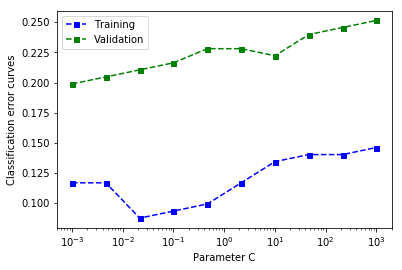

In [57]:
clf_svm_ln = SVC(kernel = "linear")
vectC = np.logspace(-3, 3, 10)

plot_curve(Xtrain,Ytrain,clf_svm_ln,vectC)

#### (b) Evaluate the performance of the model on the test set (you shall compute the accuracyand show the confusion matrix). Comment on the results

     Pour évaluer les performances de notre modèle, nous allons appeler notre fonction 
     pipeline_gridsearch et spécifier le paramètre X_test pour avoir les prédictions.
     
     Nous allons écrire une fonction qui renverra la matrice de confusion et l'accuracy

In [99]:
def plot_confusion_matrix(y_pred,y_true,title='Confusion matrix',cmap=None,normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, accuracy_score
    
    acc = accuracy_score(y_true, y_pred)
    misclass = 1 - acc
    cm = confusion_matrix(y_pred , y_true)
    target_names = list(unique_labels(y_pred, y_pred))
    print("Model accuracy: %.2f%%" % (acc * 100))
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(acc, misclass))
    plt.show()
    

Model accuracy: 79.28%


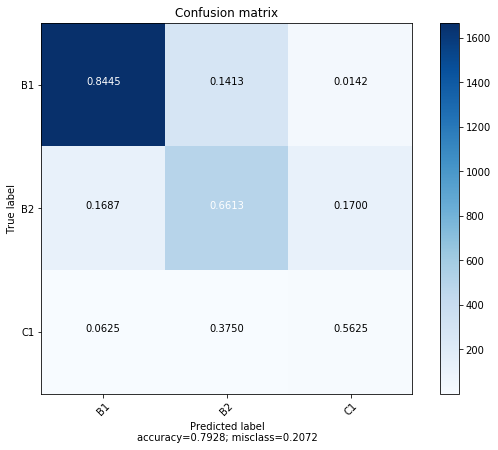

In [114]:
# predicted value using our fonction
ypred_ln = pipeline_gridsearch(Xtrain,Ytrain,steps=steps,grid_param=parametres,
                             X_test=Xtest)["predictions"]
# confusion matrix
plot_confusion_matrix(ypred_ln,Ytest)

#### 4. Now we want to learn a non-linear SVM. The kernel is left at your choice. Build and train a pipeline to select your best kernel SVM. Compare its performances to the linear SVM.

/home/soum/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


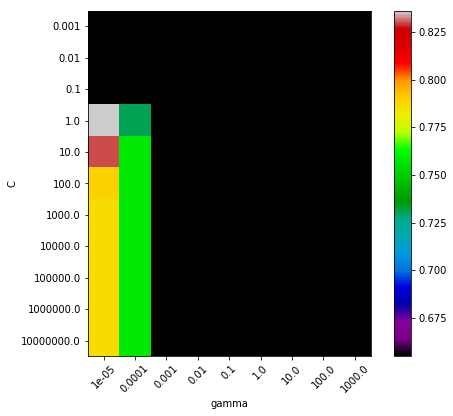

In [113]:
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3)

grid.fit(Xtrain, Ytrain)

#print("The best classifier is: ", grid.best_estimator_)

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.spectral)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

Nous voyons à travers ce que le valeur optimale du couple (C,gamma) est 1.0, 1e-05

In [115]:
ypred_krnl = grid.predict(Xtest)
acckrl = accuracy_score(ypred_krnl,Ytest)
accln = accuracy_score(ypred_ln,Ytest)
print("svm_krl accuracy: %.2f%%" % (acckrl * 100))
print("svm_ln accuracy: %.2f%%" % (accln * 100))

svm_krl accuracy: 84.47%
svm_ln accuracy: 79.28%


le svm non-linéaire discrimine mieux que le svm linéaire

#### 5.Is the classification problem well balanced ? If not, is the accuracy the best performance measure to select the optimal model ? If not, which solution can you propose ? Justify your answer.

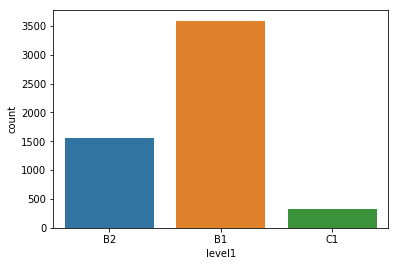

In [6]:
x = train['level1']
sns.countplot(x=x, data=train)

La répartition des classes n'est uniforme. Le niveau C1 par exemple est beaucoup moins représenté donc dans ce cas l'**accuracy** n'est approprié comme mesure de performance. IL faut plutot regarder l' **AUC** ou le **f1-score** 